In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack
#from desi_retriever.denali import get_specs
import matplotlib.cm as cm
import scipy.ndimage as sn
import my_plot_style as mps
import desispec.tsnr as dts 
mps.my_plot_style()

In [2]:
def matching_pernight_cumulative_VI_data(pernight_data,cumulative_data,target_name):
    if target_name=='BGS':
        diretory = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/cascades/3.1/BGS_ANY/'
        dataname = 'allVItiles_BGS_ANYzinfo_wVI.fits'
    
    elif target_name=='LRG':
        diretory = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/cascades/3.1/LRG/'
        dataname = 'allVItiles_LRGzinfo_wVI.fits'
    
    elif target_name=='ELG':
        diretory = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/cascades/3.1/ELG/'
        dataname = 'allVItiles_ELGzinfo_wVI.fits'
    
    VI_data = Table.read(diretory+dataname)
    VI_data = VI_data[(VI_data['subset']=='deep') & (VI_data['subset']!='All') & ((VI_data['N_VI']>0))]
    VI_data = VI_data['TARGETID','Z','TILEID','DELTACHI2','TARGET_RA','TARGET_DEC'
                        ,'FIBERFLUX_R','FLUX_R','FIBERFLUX_Z','FLUX_W1','FLUX_G','FLUX_Z','EBV','ZWARN','FIBER','best_z','best_quality','N_VI','all_VI_comments','merger_comment'].to_pandas()
    
    catalog_match = pernight_dataset.merge(everest_dataset,on='TARGETID',how='left',suffixes=("_pernight","_cumulative"))
    final_match_catalog = catalog_match[catalog_match['TILEID_pernight']==catalog_match['TILEID_cumulative']]
    
    #catalog_match = everest_data.merge(VI_data,on='TARGETID',how='left',suffixes=("","_VI"))
    #final_match_catalog = catalog_match[catalog_match['TILEID']==catalog_match['TILEID_VI']]

    final_match_catalog = final_match_catalog.merge(VI_data,on='TARGETID',how='left',suffixes=("","_VI"))
    final_match_catalog = final_match_catalog[final_match_catalog['TILEID_pernight']==final_match_catalog['TILEID']]
    final_match_catalog['dz_pernight_VI'] = abs(final_match_catalog['Z_pernight']-final_match_catalog['best_z'])/(1.+final_match_catalog['best_z'])
    final_match_catalog['dz_pernight_cumulative'] = abs(final_match_catalog['Z_pernight']-final_match_catalog['Z_cumulative'])/(1.+final_match_catalog['Z_cumulative'])

    return final_match_catalog    

In [3]:
def main_survey_selection(data,target_type):
    new_catalog = data.copy()
    new_catalog['zmag']=-2.5*np.log10(new_catalog['FLUX_Z'])+22.5-1.211*new_catalog['EBV']
    new_catalog['gmag']=-2.5*np.log10(new_catalog['FLUX_G'])+22.5-3.214*new_catalog['EBV']
    new_catalog['rmag']=-2.5*np.log10(new_catalog['FLUX_R'])+22.5-2.165*new_catalog['EBV']
    new_catalog['GTOT']=-2.5*np.log10(new_catalog['FLUX_G'])+22.5-3.214*new_catalog['EBV']
    new_catalog['GFIB']=-2.5*np.log10(new_catalog['FIBERFLUX_G'])+22.5-3.214*new_catalog['EBV']
    new_catalog['RFIB']=-2.5*np.log10(new_catalog['FIBERFLUX_R'])+22.5-2.165*new_catalog['EBV']
    new_catalog['ZFIB']=-2.5*np.log10(new_catalog['FIBERFLUX_Z'])+22.5-1.211*new_catalog['EBV']

    new_catalog['W1']=-2.5*np.log10(new_catalog['FLUX_W1'])+22.5-0.184*new_catalog['EBV']
    
    new_catalog['RZ']=new_catalog['rmag']-new_catalog['zmag']
    new_catalog['GR']=new_catalog['gmag']-new_catalog['rmag']
    new_catalog['color']=(new_catalog['zmag']-new_catalog['W1'])-1.2*(new_catalog['gmag']-new_catalog['rmag'])+1.2
    new_catalog['ZW1']=new_catalog['zmag']-new_catalog['W1']
    new_catalog['RW1']=new_catalog['rmag']-new_catalog['W1']

    if target_type=='ELG_main':
    
        SV3_selection = ((new_catalog['GTOT']>20) &
                        (new_catalog['GFIB']<24.1) &
                        (new_catalog['RZ']>0.15) & 
                        (new_catalog['GR']<0.1+0.5*new_catalog['RZ']) &
                        (new_catalog['GR']<-1.2*new_catalog['RZ']+1.6))
    
    elif target_type=='ELG_top':
    
        SV3_selection = ((new_catalog['GTOT']>20) &
                        (new_catalog['GFIB']<24.1) &
                        (new_catalog['RZ']>0.15) & 
                        (new_catalog['GR']<0.1+0.5*new_catalog['RZ']) &
                        (new_catalog['GR']<-1.2*new_catalog['RZ']+1.3))
    
    elif target_type=='ELG_low':
    
        SV3_selection = ((new_catalog['GTOT']>20) &
                        (new_catalog['GFIB']<24.1) &
                        (new_catalog['RZ']>0.15) & 
                        (new_catalog['GR']<0.1+0.5*new_catalog['RZ']) &
                        (new_catalog['GR']>-1.2*new_catalog['RZ']+1.3) & (new_catalog['GR']<-1.2*new_catalog['RZ']+1.6))

        
    elif target_type=='BGS_main':
        SV3_selection = (
            ((new_catalog['PHOTSYS']==b'S') & ((new_catalog['RFIB']<20.75) | ((new_catalog['RFIB']<21.5) & (new_catalog['color']>0)))) |            
            ((new_catalog['PHOTSYS']==b'N') & ((new_catalog['RFIB']<20.75+0.04) | ((new_catalog['RFIB']<21.5+0.04) & (new_catalog['color']>0)))))   
        #deltachi2_selection = new_catalog['DELTACHI2']>40
        #SV3_selection = SV3_selection & deltachi2_selection
    
    elif target_type=='LRG_main':
        
        SV3_selection = (
            ((new_catalog['PHOTSYS']==b'S') & (new_catalog['ZFIB']<21.7) &
            (new_catalog['ZW1']>0.8*new_catalog['RZ']-0.6) & 
            (((new_catalog['GR']>1.3) & (new_catalog['GR']>-1.55*(new_catalog['RW1']+3.13))) |  (new_catalog['RW1']>1.8)) &
            (((new_catalog['RW1']>(new_catalog['W1']-17.07)*1.8) & (new_catalog['RW1']>(new_catalog['W1']-16.17)*1))  | (new_catalog['RW1']>3.29))) |
            
            ((new_catalog['PHOTSYS']==b'N') & (new_catalog['ZFIB']<21.72) &
            (new_catalog['ZW1']>0.8*new_catalog['RZ']-0.6) & 
            (((new_catalog['GR']>1.34) & (new_catalog['GR']>-1.55*(new_catalog['RW1']+3.23))) |  (new_catalog['RW1']>1.8)) &
            (((new_catalog['RW1']>(new_catalog['W1']-17.24)*1.83) & (new_catalog['RW1']>(new_catalog['W1']-16.33)*1))  | (new_catalog['RW1']>3.39)))
        )
       # deltachi2_selection = (new_catalog['Z']>0.4) & (new_catalog['Z']<1.4) & (new_catalog['DELTACHI2']>15)
       # SV3_selection = SV3_selection & deltachi2_selection    
    return new_catalog[SV3_selection]

In [4]:
directory = '/global/cfs/cdirs/desi/spectro/redux/everest/zcatalog/'

In [5]:
pernight_data = Table.read('/global/u2/t/tlan/ztile-sv1-perexp.fits',1)
everest_all = Table.read(directory+'ztile-sv1-cumulative.fits',1)
pernight_dataset = pernight_data['TARGETID','Z','TILEID','DELTACHI2','TARGET_RA','TARGET_DEC','COADD_EXPTIME','ZWARN','SPECTYPE','SV1_DESI_TARGET','PHOTSYS','COADD_FIBERSTATUS','TSNR2_LRG',
                              ].to_pandas()
everest_dataset = everest_all['TARGETID','Z','TILEID','DELTACHI2','TARGET_RA','TARGET_DEC','COADD_EXPTIME','COADD_FIBERSTATUS'
                              ,'FIBERFLUX_R','FIBERFLUX_G','FLUX_R','FIBERFLUX_Z','FLUX_W1','FLUX_G','FLUX_Z','EBV','ZWARN','FIBER','FIBERTOTFLUX_G','TSNR2_LRG'].to_pandas()

catalog_match = pernight_dataset.merge(everest_dataset,on='TARGETID',how='left',suffixes=("_pernight","_cumulative"))
final_match_catalog=matching_pernight_cumulative_VI_data(pernight_dataset,everest_dataset,'LRG')
#final_match_catalog = catalog_match[catalog_match['TILEID_pernight']==catalog_match['TILEID_cumulative']]
#final_match_catalog['dz_pernight_cumulative'] = abs(final_match_catalog['Z_pernight']-final_match_catalog['Z_cumulative'])/(1.+final_match_catalog['Z_cumulative'])


In [6]:
final_match_catalog['EFFTIME_LRG_pernight']=dts.tsnr2_to_efftime(final_match_catalog['TSNR2_LRG_pernight'], 'LRG')
final_match_catalog['EFFTIME_LRG_cumulative']=dts.tsnr2_to_efftime(final_match_catalog['TSNR2_LRG_cumulative'], 'LRG')

INFO:tsnr.py:444:get_ensemble: for /global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desimodel/master/data/tsnr/tsnr-ensemble-gpbdark.fits apply scale factor = 1.000
INFO:tsnr.py:444:get_ensemble: for /global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desimodel/master/data/tsnr/tsnr-ensemble-elg.fits apply scale factor = 1.261
INFO:tsnr.py:444:get_ensemble: for /global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desimodel/master/data/tsnr/tsnr-ensemble-gpbbright.fits apply scale factor = 1.000
INFO:tsnr.py:444:get_ensemble: for /global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desimodel/master/data/tsnr/tsnr-ensemble-lya.fits apply scale factor = 0.998
INFO:tsnr.py:444:get_ensemble: for /global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desimodel/master/data/tsnr/tsnr-ensemble-bgs.fits apply scale factor = 2.652
INFO:tsnr.py:444:get_ensemble: for /global/common/software/desi/cori/desiconda/202008

(array([9.021e+03, 1.294e+03, 2.370e+02, 1.985e+03, 7.902e+03, 5.482e+03,
        4.265e+03, 3.526e+03, 3.153e+03, 2.662e+03, 2.236e+03, 1.974e+03,
        1.968e+03, 2.029e+03, 2.647e+03, 3.227e+03, 3.400e+03, 2.765e+03,
        1.977e+03, 1.630e+03, 1.173e+03, 9.370e+02, 7.360e+02, 6.010e+02,
        3.510e+02, 1.160e+02, 3.600e+01, 1.200e+01, 6.000e+00, 6.000e+00,
        4.000e+00, 9.000e+00, 2.000e+00, 5.000e+00, 3.000e+00, 7.000e+00,
        1.000e+00, 2.000e+00, 3.000e+00, 3.000e+00, 2.000e+00, 3.000e+00,
        0.000e+00, 1.000e+00, 4.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00]),
 array([   0.,   40.,   80.,  120.,  160.,  200.,  240.,  280.,  320.,
         360.,  400.,  440.,  480.,  520.,  560.,  600.,  640.,  680.,
         720.,  760.,  800.,  840.,  880.,  920.,  960., 1000., 1040.,
        1080., 1120., 1160., 1200., 1240., 1280., 1320., 1360., 1400.,
        1440., 1480., 1520., 1560., 1600., 1640., 1680., 1720., 1760.,
        1800., 1840.,

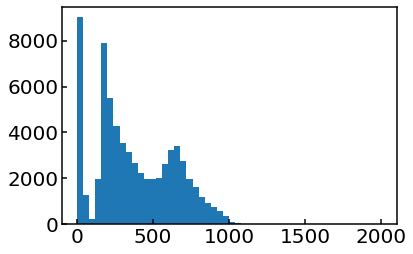

In [35]:
plt.hist(final_match_catalog['EFFTIME_LRG_pernight'],range=(0,2000),bins=50)

In [47]:
from desitarget.sv1 import sv1_targetmask
#LRG_mask = (final_match_catalog["SV1_DESI_TARGET"] & sv1_targetmask.desi_mask["LRG"]) > 0
#QSO_mask = ((final_match_catalog["SV1_DESI_TARGET"] & sv1_targetmask.desi_mask["QSO"]) > 0)
exposure_mask = (final_match_catalog['EFFTIME_LRG_pernight']>700) & (final_match_catalog['EFFTIME_LRG_pernight']<1200)# & (final_match_catalog['EFFTIME_LRG_cumulative']>3000)# & (final_match_catalog['EFFTIME_LRG_pernight']<10000)
'''
quality_mask = ((final_match_catalog['DELTACHI2_cumulative']>15) & (final_match_catalog['Z_cumulative']<1.4) & (final_match_catalog['Z_cumulative']>0.4) & 
    #(final_match_catalog['ZWARN_cumulative']==0) &
    (final_match_catalog['COADD_FIBERSTATUS_cumulative']==0) &
    #(final_match_catalog['ZWARN_pernight']==0) &
    (final_match_catalog['COADD_FIBERSTATUS_pernight']==0)
               )
'''               
quality_mask = ((final_match_catalog['best_quality']>=2.5) & (final_match_catalog['best_z']<1.4) & (final_match_catalog['best_z']>0.4) & 
    #(final_match_catalog['ZWARN_cumulative']==0) &
    (final_match_catalog['COADD_FIBERSTATUS_cumulative']==0) &
    #(final_match_catalog['ZWARN_pernight']==0) &
    (final_match_catalog['COADD_FIBERSTATUS_pernight']==0)
               )

In [48]:
LRG = final_match_catalog[LRG_mask & exposure_mask & quality_mask]
LRG_main = main_survey_selection(LRG,'LRG_main')

In [49]:
len(LRG_main)

2218

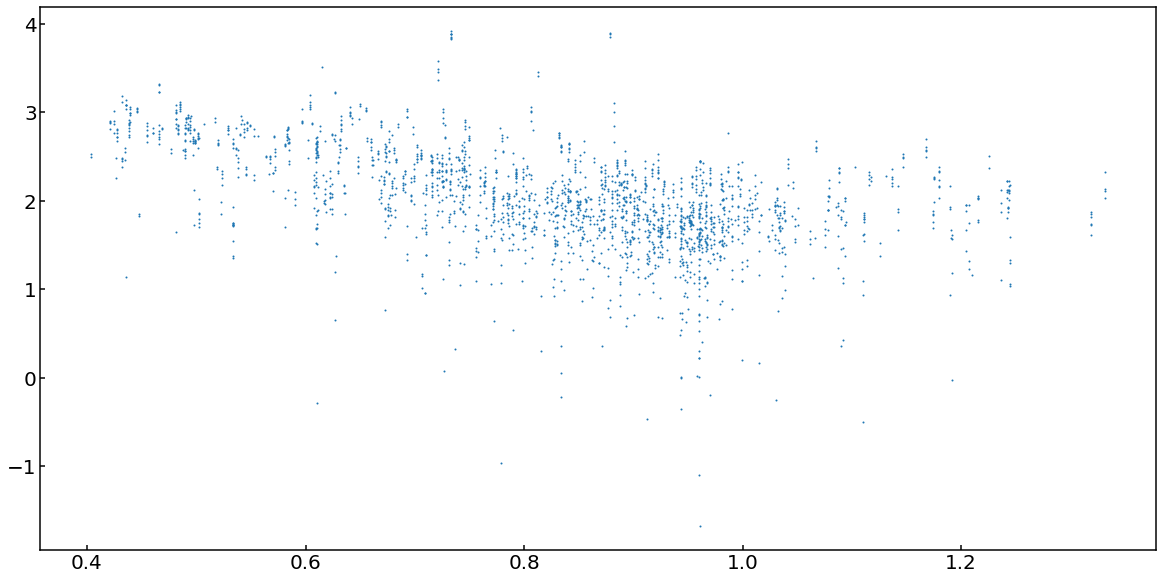

In [50]:
plt.figure(figsize=(20,10))
plt.scatter(LRG_main['best_z'],np.log10(LRG_main['DELTACHI2_pernight']),s=1)

In [51]:
short_exposure_mask = (LRG_main['DELTACHI2_pernight']>15) & (LRG_main['dz_pernight_VI']<0.0033)# & (LRG_main['Z_pernight']<1.4)

In [52]:
LRG_short = LRG_main[short_exposure_mask]

In [53]:
len(LRG_short)

2067

In [54]:
len(LRG_main)

2218

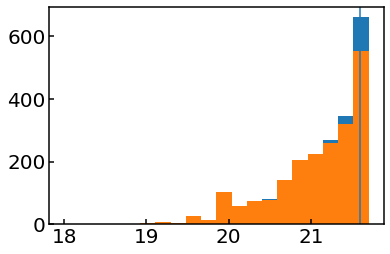

In [55]:
out1 = plt.hist(LRG_main['ZFIB'],range=(18,21.7),bins=20)
out2 = plt.hist(LRG_short['ZFIB'],range=(18,21.7),bins=20)
plt.axvline(21.6)

In [56]:
1.*out2[0]/out1[0]

<ipython-input-56-d3fcbf0b0ad7>:1: RuntimeWarning: invalid value encountered in true_divide
  1.*out2[0]/out1[0]


array([       nan,        nan,        nan,        nan,        nan,
       0.6       , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.95      , 1.        ,
       0.99512195, 0.99553571, 0.96268657, 0.92507205, 0.83812405])

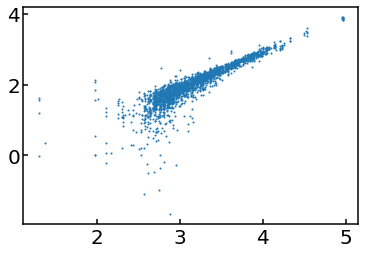

In [57]:
plt.scatter(np.log10(LRG_main['DELTACHI2_cumulative']),np.log10(LRG_main['DELTACHI2_pernight']),s=1)